In [1]:
%load_ext autoreload
%autoreload 2


%pylab inline

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms

import numpy as np
import tqdm
import torch
import yaml

from models import VAE_3D, VQ_VAE, PixelCNN_VQVAE, VAE_complex
from utils import get_dataloader

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [28]:
img_size = 256
mean=(0.485, 0.456, 0.406)
std=(0.229, 0.224, 0.225)

crop = transforms.RandomResizedCrop(img_size, scale = [0.8,1.0],ratio = [0.9,1.1])
dataset = torchvision.datasets.OxfordIIITPet(root = './', split = 'trainval', transform=transforms.Compose([
            crop,
            transforms.Resize(img_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean = mean, std =std)
        ]), download = True)

unnormalize =  transforms.Compose([
        transforms.Normalize(mean = 0., std = 1/torch.tensor(std)),
        transforms.Normalize(mean = -torch.tensor(mean), std = 1.)
    ])


In [22]:
BS = 64
dataloader = DataLoader(dataset, batch_size=BS, shuffle = True)

In [2]:
BS = 64
img_size = 256
mean=(0.485, 0.456, 0.406)
std=(0.229, 0.224, 0.225)
dataloader, classes, unnormalize = get_dataloader(img_size = img_size,batch_size = BS,animals = ['cat'], norm_values = (mean, std))
classes

['cat']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


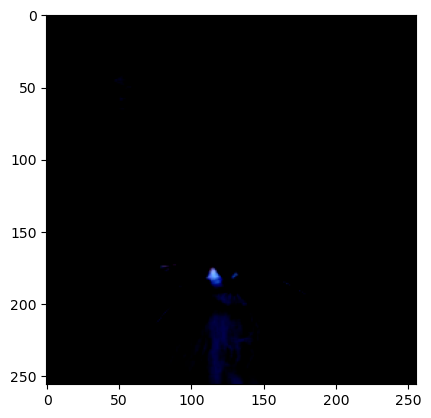

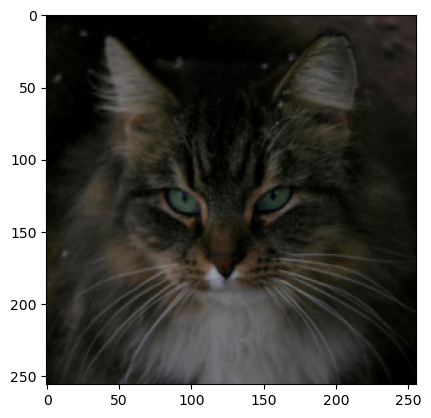

In [3]:
imshow(dataloader.dataset[0][0].permute(1,2,0).numpy())
show()
imshow(unnormalize(dataloader.dataset[0][0]).permute(1,2,0).numpy())

In [19]:
dataloader.dataset[0][0].shape

torch.Size([3, 256, 256])

In [2]:
'''BS = 64
img_size = 128
dataloader, classes = get_dataloader(img_size = img_size,batch_size = BS)
device = torch.device('cuda')

print(classes)
'''

['cat', 'dog', 'wild']


In [4]:
test_dataloader, _, _ = get_dataloader(img_size = img_size,batch_size = BS, split = 'val',animals = ['cat'], norm_values=(mean, std))

# More complex VAE

In [5]:
from models import VAE_complex

with open('./VAEcomplex_AFHQ_params.yaml', 'rb') as f:
    config_complex = yaml.safe_load(f)
device = torch.device('cuda')
model_complex = VAE_complex(config_complex['model parameters'])
model_complex = model_complex.to(device)

In [6]:
from torchview import draw_graph

x = next(iter(dataloader))[0]
model_graph = draw_graph(model_complex, input_data = x.float().to(device))
#model_graph.visual_graph.render(format = 'png')
#model_graph.visual_graph

In [7]:
lr = 1e-4
kl_weight = 0.0000025
# kl_weight multiplied by 100 seems to work better
optim = torch.optim.Adam(model_complex.parameters(), lr = lr)
epochs = 20

def loss_function(x, x_pred, mu, logvar, kl_weight):
    loss_mse = F.mse_loss(x, x_pred)
    loss_kl = torch.mean(0.5 * torch.sum(1-mu**2 - logvar.exp() +logvar, dim = 1), dim = 0)
    loss = loss_mse - kl_weight * loss_kl
    
    return loss, loss_mse.item(), -loss_kl


In [8]:
losses = []
losses_mse = []
model_complex.train()

for _ in range(epochs):
    pbar = tqdm.tqdm(dataloader)
    for batch, _ in pbar:
        x = batch.to(device)
        optim.zero_grad()

        out, mu, logvar = model_complex(x.float())

        loss, loss_mse, loss_kl = loss_function(x, out, mu, logvar, kl_weight)

        loss.backward()
        optim.step()   
        #scheduler.step(loss)

        losses.append(loss.item())
        losses_mse.append(loss_mse)

        pbar.set_description(f'Loss: %.3f, loss MSE: %.3f, loss KL: %.3f' % (loss.item(), loss_mse, loss_kl))   


Loss: 0.812, loss MSE: 0.811, loss KL: 437.312: 100%|██████████| 81/81 [03:43<00:00,  2.76s/it]


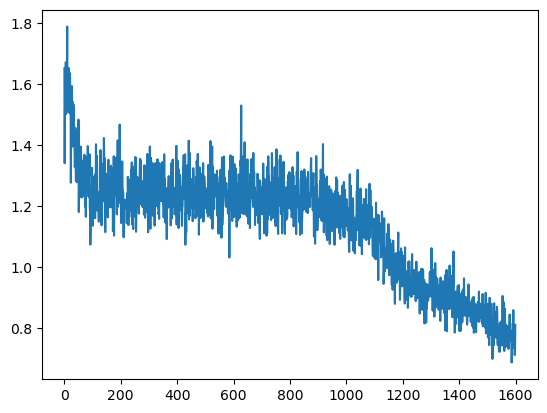

In [22]:
plot(losses[20:])

In [49]:
F.mse_loss(out, x.float())


tensor(0.9860, device='cuda:0', grad_fn=<MseLossBackward0>)

In [27]:
#torch.save(model_complex.state_dict(), './model_saves/AFHQcat_VAEcomplex_20iter.pth')
#model_complex.load_state_dict(torch.load('./model_saves/AFHQcat_VAEcomplex_20iter.pth'))

<All keys matched successfully>

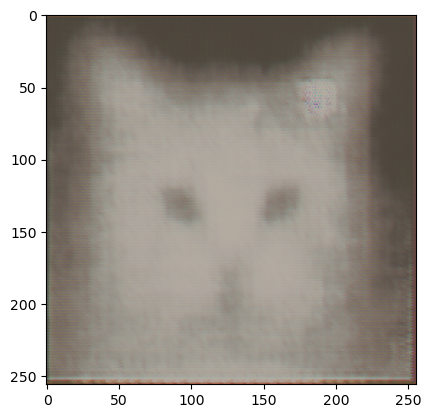

In [28]:
with torch.no_grad():
    test_load,_,_ = model_complex(x)

imshow(unnormalize(test_load)[0].cpu().permute(1,2,0).numpy())

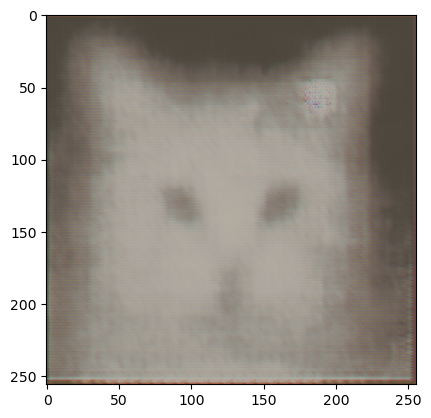

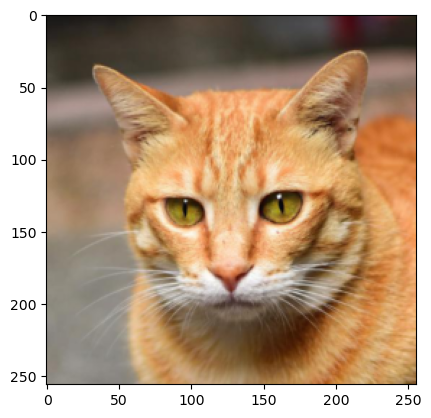

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


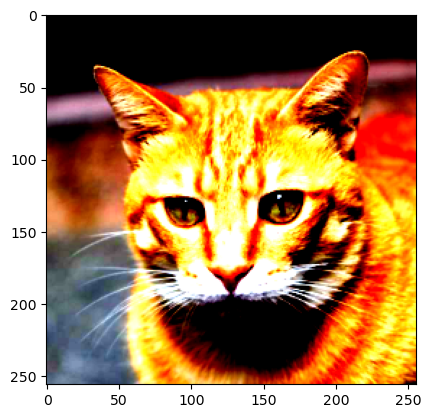

In [23]:
imshow(unnormalize(out.cpu())[0].detach().permute(1,2,0).numpy())
show()
imshow(unnormalize(x.cpu())[0].cpu().permute(1,2,0).numpy())
show()
imshow(x[0].cpu().permute(1,2,0).numpy())

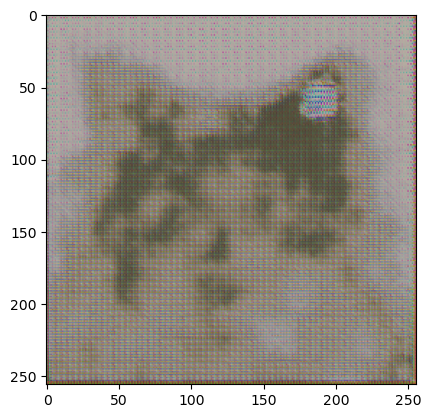

In [25]:
pred = model_complex.sample(1)
imshow(unnormalize(pred.cpu())[0].permute(1,2,0).numpy())

In [37]:
#torchvision.utils.save_image(unnormalize(pred), './output_images/VAEother_sample100iter.png')

In [26]:
test_dataloader, _ = get_dataloader(img_size = 128,batch_size = BS, split = 'val', animals = ['cat'])


In [26]:
batch = next(iter(test_dataloader))[0]
with torch.no_grad():
    x_pred, mu, logvar = model_complex(batch.to(device).float())
    loss = loss_function(batch.to(device)/2+.5, x_pred, mu, logvar, kl_weight=kl_weight)

In [27]:
loss

tensor(32246.8379, device='cuda:0')

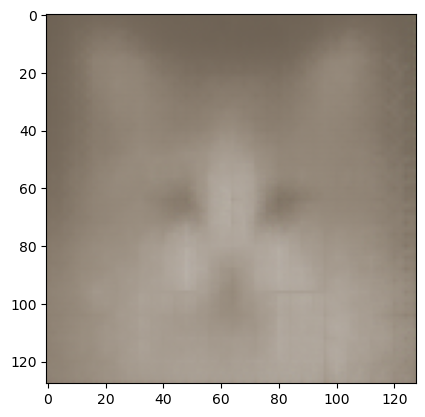

In [28]:
imshow(x_pred[0].detach().permute(1,2,0).cpu().numpy())

In [4]:
from models import VAE_other
device = torch.device('cuda')
channels = [16, 32, 64, 128, 256, 512]
latent_dim = 512

model_complex = VAE_other(channels, latent_dim)
model_complex.to(device)


VAE_other(
  (blocks_conv): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (3): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (4): Se

In [21]:
out = model_complex(x.to(device))
out[0].shape

torch.Size([128, 3, 256, 256])